## Week 3: Documentation with Jupyter Notebooks
---
Labeeb Ahmed

In [71]:
# import modules
import sys
import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# check versions
sys.version # confirm running python 3.5.x
gdal.VersionInfo()


'2020200'

**RGBraster2array() function** can read and convert raster images to numpy array

In [72]:
def RGBraster2array(RGB_geotif):
    """RGBraster2array reads in a NEON AOP geotif file and returns 
    a numpy array, and header containing associated metadata with spatial information.
    --------
    Parameters
        RGB_geotif -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    array:
        numpy array of geotif values
    metadata:
        dictionary containing the following metadata (all strings):
            array_rows
            array_cols
            bands
            driver
            projection
            geotransform 
            pixelWidth 
            pixelHeight 
            extent
            noDataValue  
            scaleFactor 
    --------
    Example Execution:
    --------
    RGB_geotif = '2017_SERC_2_368000_4306000_image.tif'
    RGBcam_array, RGBcam_metadata = RGBraster2array(RGB_geotif) """

    metadata = {}
    dataset = gdal.Open(RGB_geotif)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    for i in range(1, dataset.RasterCount+1):
        band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        band[band==metadata['noDataValue']]=np.nan
        band = band/metadata['scaleFactor']
        array[...,i-1] = band

    return array, metadata


### Define RGB_geotif path and run RGBraster2array()

In [73]:
RGB_geotif = 'C:/Users/CBPStaff/Neon_Data/2017_SERC_2_368000_4306000_image.tif'
SERC_RGBcam_array, SERC_RGBcam_metadata = RGBraster2array(RGB_geotif)

SERC_RGBcam_array.shape # print array dim

(10000, 10000, 3)

In [74]:
print (sorted(SERC_RGBcam_metadata.keys())) #Print array metadata keys

['array_cols', 'array_rows', 'bands', 'driver', 'ext_dict', 'extent', 'geotransform', 'noDataValue', 'pixelHeight', 'pixelWidth', 'projection', 'scaleFactor']


### Plotting RGB Camera Image
Using plot_band_array(), we'll plot the array data

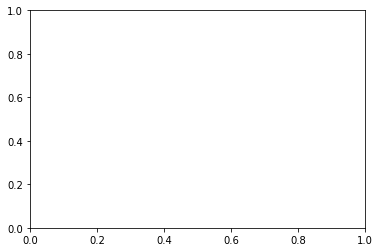

In [75]:
def plot_band_array(band_array,
                    refl_extent,
                    colorlimit,
                    ax=plt.gca(),
                    title='',
                    cbar ='on',
                    cmap_title='',
                    colormap='spectral'):

    '''plot_band_array reads in and plots a single band or an rgb band combination of a reflectance array
    --------
    Parameters
    --------
        band_array: flightline array of reflectance values, created from h5refl2array function
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] from h5refl2array function
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
    --------
    Returns 
        plots array of single band or RGB if given a 3-band 
    --------
    Example:
    --------
    plot_band_array(SERC_RGBcam_array, 
                    SERC_RGBcam_metadata['extent'],
                    (1,255),
                    title='SERC RGB Camera Tile',
                    cbar='off')'''

    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

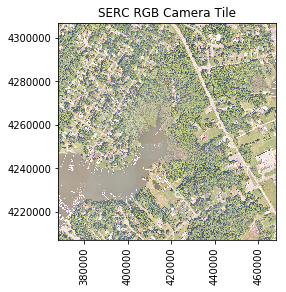

In [78]:
# display the array
plot_band_array(SERC_RGBcam_array,
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC RGB Camera Tile',
                cbar='off')

### Plot histogram of red band

Text(0,0.5,'Frequency')

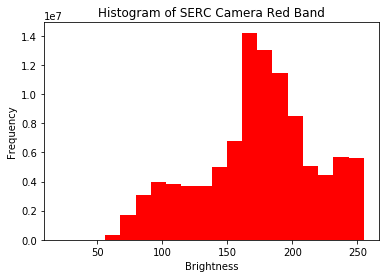

In [84]:
# plot the histogram
""" Note: [:,:,0] is band 1 or red,
          [:,:,1] is band 2 or blue and etc"""

plt.hist(np.ravel(SERC_RGBcam_array[:,:,0]), 20, color='red');
plt.title('Histogram of SERC Camera Red Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

# Challenge Exercises
---
#### (1) Plot histograms of green and blue bands

Text(0,0.5,'Frequency')

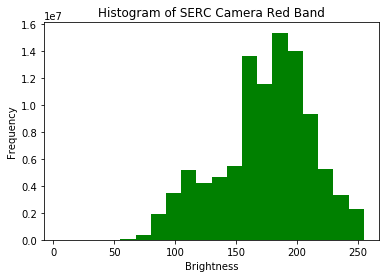

In [85]:
# Plot green band
plt.hist(np.ravel(SERC_RGBcam_array[:,:,1]), 20, color='green');
plt.title('Histogram of SERC Camera Red Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

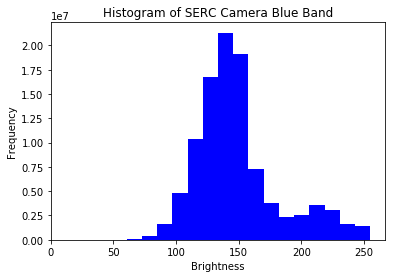

In [86]:
# Plot blue band
plt.hist(np.ravel(SERC_RGBcam_array[:,:,2]), 20, color='blue');
plt.title('Histogram of SERC Camera Blue Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

#### (2) Data exploration

In [106]:
# (a) get array min & max values
def get_mn_mx(array, band):
    a = np.ravel(array[:,:,band])
    return np.amin(a), np.amax(a)

for band in range(3):
    mn, mx = get_mn_mx(SERC_RGBcam_array, band)
    print ("Band #{}: min={}; max={}".format(band, mn, mx))

# (b) raster projection
SERC_RGBcam_metadata['projection']

Band #0: min=21; max=255
Band #1: min=5; max=255
Band #2: min=12; max=255


'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'

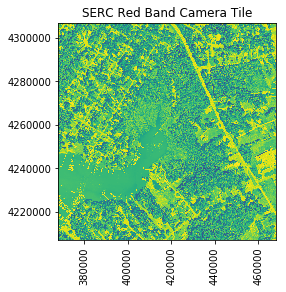

In [108]:
# (c) plot_band_array to plot all three bands separately 

# Red band
plot_band_array(SERC_RGBcam_array[:,:,0],
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC Red Band Camera Tile',
                cbar='off')
    

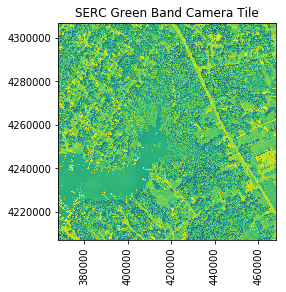

In [109]:
# Green band
plot_band_array(SERC_RGBcam_array[:,:,1],
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC Green Band Camera Tile',
                cbar='off')

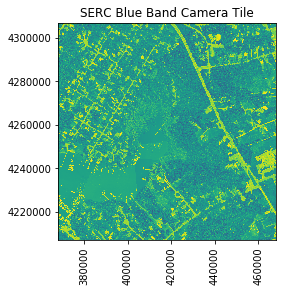

In [110]:
# Blue band
plot_band_array(SERC_RGBcam_array[:,:,2],
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC Blue Band Camera Tile',
                cbar='off')